## QPR problem solving using QCNN

**Quantum phase recognition (QPR)** asks whether a given input quantum state $\rho_{in}$ belongs to a particular quantum phase of matter. "We assume that $\rho_{in}$ is prepared in a physical system without direct access to its classical description."

Apply **quantum convolutional neural network (QCNN)** to QPR in a class oc 1D many-body systems. Specifically, a $\mathbb{Z}_2 \times \mathbb{Z}_2$ symmetry-protected topological (SPT) phase $\mathcal{P}$, a phsase containing the $S=1$ Haldane chain, and group state $\{ \Psi_G \}$ of a family of Hamiltonians on a spin-1/2 cahin with open boundary conditions: $$ \hat{H} = -J \sum_{i=1}^{N-2}(\hat{Z}_{i}\hat{X}_{i+1}\hat{Z}_{i+2}) -h_{1}\sum_{i=1}^{N}(\hat{X}_{i}) -h_{2}\sum_{i=1}^{N-1}(\hat{X}_{i}\hat{X}_{i+1}) $$ where $X_i, Z_i$ are Pauli operators for the spin at site $i$, and $h_1$, $h_2$ and $J$ are parameters of the Hamiltonian.

The authors begin by considering the ground state wavefunctions of a family of hamiltonians parameterized by $h_{1}, h_{2}$. The ground states of this system exist in certain  phases of matter (paramagnetic, antiferromagnetic, SPT) depnding on the values of $h_{1}, h_{2}$ ($J$ was set without loss of generality $J = 1$).
The authors then ask the question, is it possible for a quantum machine learning model to determine which state a of matter a particular wave function is from? The model used is the QCNN model they present in the paper.  

The training data set consists of 40 ground state wave functions for the hamiltonian with $h_{2} = 0$ and $h_{1}$ sampled at regular intervals between $[0, 1.6]$. The testing data set consists of (64 x 64) samples of $h_{2} \in [-1.5, 1.5]$ , $h_{1} \in [0, 1.6]$. The output of the Qcnn would be a real number between (-1, 1) (this was a measurement of the expectation of the pauli-X operator on the middle qubit). 

The ground truth phase boundaries between the SPT phase and the paramagnetic or anti-ferromagnetic phases was derived using DMRG simulations. Then the SPT phase was labeled 1 and the other two phases as 0. If the QCNN could correctly produce the correct label given the ground state wave function, then we would have successfuly learned how to distinguish between the quantum phases of matter! 


- Our goal is to identify a QCNN capable of distinguishing between SPT ($label=1$) and other phase ($label=0$).

## Date and Time Information
- When saving everything from model parameters to plot images, we will save its file name with the time information.y

In [1]:
import datetime

# Get the current date and time
current_datetime = datetime.datetime.now()

# Format the date and time as a string
date_time_str = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the object name
object_name = f"model_{date_time_str}"

# Now 'object_name' contains the desired name with date and time info
print(object_name)

model_20231108_100216


In [2]:
date_str = date_time_str[0:8]

## Create result folder

In [3]:
import os

# Define the folder name
date_str = date_time_str[0:8]
result_folder_name = f'result_simul\{date_str}'

# Create the folder if it doesn't exist
if not os.path.exists(result_folder_name):
    os.makedirs(result_folder_name)

## Data

In [4]:
import copy
import sys 
import numpy as np
import matplotlib.pyplot as plt 

sys.path.insert(0, "qml_src/")

from qml import qcnn as q
from qml import layers as cl # custom layers 

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch import manual_seed, tensor, Tensor, float32

In [5]:
## read / import data 
num_qubits = 8
training_fname = "./data_fldr/dataset_n={}_train.txt".format(num_qubits)
test_fname = "./data_fldr/dataset_n={}_test.txt".format(num_qubits)

def read_eigenvectors(file):
    with open(file, 'r+') as f:
        textData = f.readlines()

        h_vals = []
        for i in range(len(textData)):
            h1h2, eigenvector = textData[i].split("_")

            h_vals.append(tuple(map(float, h1h2[1: -1].split(', '))))
            textData[i] = eigenvector

        return h_vals, np.loadtxt(textData, dtype=complex)

h1h2_train, train_data = read_eigenvectors(training_fname)
h1h2_test, test_data = read_eigenvectors(test_fname)

# To get the correct labels of the training set we use the fact that data points with
# h1 <= 1 are in the SPT phase and thus assigned the label 1 while h1 > 1 are in the paramagnetic phase 
# This is only true for the training set which has h2 = 0 for all samples, 

labels = np.zeros(40)
test_labels = np.zeros(4096)


for index, h1h2 in enumerate(h1h2_train):
    h1, h2 = h1h2
    if h1 <= 1:
        # Label = 1: SPT phase, and Label = 0: Other two phases 
        labels[index] = 1.0
    # else:
        # Label = 1: SPT phase, and Label = -1: Other two phases 
        # labels[index] = -1.0

In [6]:
# Function that calculates the shape of a coordinate_list
def get_shape_of_coordinate_list(coord_list):
    num_rows = len(coord_list)
    num_columns = 0

    if num_rows > 0:
        num_columns = len(coord_list[0])

    for coordinate in coord_list:
        if len(coordinate) != num_columns:
            raise ValueError("The list does not have a consistent number of columns.")

    return num_rows, num_columns

# We have a list of h1 & h2 values of train / test data.
print("h1h2_train:")
print(type(h1h2_train))
print(f"The shape of the list is {get_shape_of_coordinate_list(h1h2_train)}.")
print()
print("h1h2_test:")
print(type(h1h2_test))
print(f"The shape of the list is {get_shape_of_coordinate_list(h1h2_test)}.")

h1h2_train:
<class 'list'>
The shape of the list is (40, 2).

h1h2_test:
<class 'list'>
The shape of the list is (4096, 2).


In [7]:
h1h2_train[0:5]

[(0.0, 0.0),
 (0.041025641025641026, 0.0),
 (0.08205128205128205, 0.0),
 (0.12307692307692308, 0.0),
 (0.1641025641025641, 0.0)]

In [8]:
# Also, we have two arrays of the quantum states of train / test data.
print("train_data:")
print(type(train_data))
print(f"The shape of the data is {train_data.shape}.")
print()
print("test_data:")
print(type(test_data))
print(f"The shape of the data is {test_data.shape}.")

train_data:
<class 'numpy.ndarray'>
The shape of the data is (40, 256).

test_data:
<class 'numpy.ndarray'>
The shape of the data is (4096, 256).


In [9]:
# Count the complex numbers that has imaginary number value equal to zero.
print("train_data:")
print(sum(sum(train_data.imag==0)))
print(f"Is all the coefficients are real numbers? The answer is ({sum(sum(train_data.imag==0)) == train_data.shape[0]*train_data.shape[1]}).")
print()
print("test_data:")
print(sum(sum(test_data.imag==0)))
print(f"Is all the coefficients are real numbers? The answer is ({sum(sum(test_data.imag==0)) == test_data.shape[0]*test_data.shape[1]}).")

train_data:
10240
Is all the coefficients are real numbers? The answer is (True).

test_data:
1048576
Is all the coefficients are real numbers? The answer is (True).


- You would find that all the `txt` file that has the amplitude values are all real values, not complex values.
- So, when we are making Train / Test dataset for `PyTorch`, we will upload those values as *`float`*.

In [10]:
# Label of the train and test data of quantum states.
print(type(h1h2_train))
print(len(h1h2_train))
print(h1h2_train[0:5])
print()
print(type(h1h2_test))
print(len(h1h2_test))
print(h1h2_test[0:5])
print()
print(type(labels))
print(len(labels))
print(labels)

<class 'list'>
40
[(0.0, 0.0), (0.041025641025641026, 0.0), (0.08205128205128205, 0.0), (0.12307692307692308, 0.0), (0.1641025641025641, 0.0)]

<class 'list'>
4096
[(0.0, -1.6), (0.0, -1.5492063492063493), (0.0, -1.4984126984126984), (0.0, -1.4476190476190478), (0.0, -1.396825396825397)]

<class 'numpy.ndarray'>
40
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
# Input quantum state of the train and test data of quantum states.
print(type(train_data))
print(len(train_data))
print(train_data.shape)
print(train_data[0:5])
print()
print(type(test_data))
print(len(test_data))
print(test_data.shape)
print(test_data[0:5])

<class 'numpy.ndarray'>
40
(40, 256)
[[ 0.00257117+0.j -0.11809442+0.j  0.00257117+0.j ... -0.0132333 +0.j
  -0.03869079+0.j -0.0132333 +0.j]
 [-0.07040048+0.j -0.06512023+0.j -0.06648038+0.j ... -0.06648038+0.j
  -0.06512023+0.j -0.07040048+0.j]
 [ 0.07870273+0.j  0.06786459+0.j  0.07073562+0.j ...  0.07073562+0.j
   0.06786459+0.j  0.07870273+0.j]
 [ 0.08736884+0.j  0.07074493+0.j  0.07526369+0.j ...  0.07526369+0.j
   0.07074493+0.j  0.08736884+0.j]
 [ 0.09633384+0.j  0.07376331+0.j  0.08004398+0.j ...  0.08004398+0.j
   0.07376331+0.j  0.09633384+0.j]]

<class 'numpy.ndarray'>
4096
(4096, 256)
[[-0.10615929+0.j -0.0196573 +0.j -0.01969027+0.j ... -0.01969027+0.j
  -0.0196573 +0.j -0.10615929+0.j]
 [-0.1072965 +0.j -0.0203954 +0.j -0.02073555+0.j ... -0.02073555+0.j
  -0.0203954 +0.j -0.1072965 +0.j]
 [ 0.10853577+0.j  0.021194  +0.j  0.02189032+0.j ...  0.02189032+0.j
   0.021194  +0.j  0.10853577+0.j]
 [ 0.10988645+0.j  0.02206087+0.j  0.02317007+0.j ...  0.02317007+0.j
   0.02206

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

# Train Dataset
# -------------

# Define your custom dataset class
class MyDataset_train(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 5
# n_samples = len(train_data)

# Convert data and labels to tensors
data_tensor = torch.tensor(train_data, dtype=torch.float)
label_tensor = torch.tensor(labels, dtype=torch.float)

# Create an instance of your custom dataset
train_dataset = MyDataset_train(data_tensor, label_tensor)

# Define torch DataLoader with the data
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\user1\AppData\Local\Temp\ipykernel_21956\3503074924.py:26: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ..\aten\src\ATen\native\Copy.cpp:276.)
  data_tensor = torch.tensor(train_data, dtype=torch.float)


- The <font color="blue">*"UserWarning: Casting complex values to real discards the imaginary part"*</font> is okay, since we have checked that all the imaginary number are equal to zero.

- Why have we taking this work process?
    - It was neccesary since all the raw files from `txt` are saved in complex data type.

In [13]:
type(train_dataset)

__main__.MyDataset_train

In [14]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [15]:
print(train_dataset.data)
print(train_dataset.data.shape)
print()
print(train_dataset.targets)
print(train_dataset.targets.shape)
print()
print(train_loader)

tensor([[ 0.0026, -0.1181,  0.0026,  ..., -0.0132, -0.0387, -0.0132],
        [-0.0704, -0.0651, -0.0665,  ..., -0.0665, -0.0651, -0.0704],
        [ 0.0787,  0.0679,  0.0707,  ...,  0.0707,  0.0679,  0.0787],
        ...,
        [-0.1292, -0.0969, -0.1042,  ..., -0.1042, -0.0969, -0.1292],
        [-0.1275, -0.0962, -0.1032,  ..., -0.1032, -0.0962, -0.1275],
        [-0.1259, -0.0956, -0.1022,  ..., -0.1022, -0.0956, -0.1259]])
torch.Size([40, 256])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
torch.Size([40])



In [16]:
# Test Dataset
# -------------

# Define your custom dataset class
class MyDataset_test(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
# Set test shuffle seed (for reproducibility)
manual_seed(7)

# n_samples = len(test_data)

# Convert test data to a tensor
test_data_tensor = torch.tensor(test_data, dtype=torch.float)

# Create an instance of your custom dataset for test data
test_dataset = MyDataset_test(test_data_tensor)

# Define DataLoader for test data
test_batch_size = 5  # Use the batch size you prefer for testing
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)  # No need to shuffle test data

In [17]:
print(test_data_tensor)
print(test_data_tensor.shape)

tensor([[-0.1062, -0.0197, -0.0197,  ..., -0.0197, -0.0197, -0.1062],
        [-0.1073, -0.0204, -0.0207,  ..., -0.0207, -0.0204, -0.1073],
        [ 0.1085,  0.0212,  0.0219,  ...,  0.0219,  0.0212,  0.1085],
        ...,
        [ 0.0846,  0.0750,  0.0780,  ...,  0.0780,  0.0750,  0.0846],
        [-0.0841, -0.0748, -0.0777,  ..., -0.0777, -0.0748, -0.0841],
        [-0.0837, -0.0745, -0.0774,  ..., -0.0774, -0.0745, -0.0837]])
torch.Size([4096, 256])


## Device and Primitives (Sampler or Estimator)

In [18]:
# # Save & Load Our Runtime service credentials.
# from qiskit_ibm_runtime import QiskitRuntimeService

# # MY_IBM_QUANTUM_API_TOKEN = 'FROM IBM Quantum Platform'
# # # Save your credentials on disk.
# # QiskitRuntimeService.save_account(channel='ibm_quantum', token=MY_IBM_QUANTUM_API_TOKEN)

# # # Instance: ibm-q/open/main
# # service = QiskitRuntimeService(
# #     channel='ibm_quantum',
# #     instance='ibm-q/open/main',
# # )

# # Instance: ibm-q-yonsei/internal/default
# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance='ibm-q-yonsei/internal/default',
# )

# # Check the available backends.
# backends = service.backends()
# print(backends)

# # Filter the available backends.
# backends = service.backends(simulator=False, min_num_qubits=5)
# print(backends)

# # Get the least busy backend from the available ones.
# chosen_backend = service.least_busy(simulator=False, min_num_qubits=None)
# chosen_backend

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler as IbmSampler
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_ibm_runtime import Options
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import (
    FakeVigoV2,
    FakeJakarta,
    FakeGuadalupe,
    FakeKolkata,
    FakeMumbai
)

In [20]:
# example from:
# https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html

from qiskit_aer.noise import pauli_error

def create_noise_model():
    # Example error probabilities
    p_reset = 0.03
    p_meas = 0.1
    p_gate1 = 0.0000001 # 5

    # QuantumError objects
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    #noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    #noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    #noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_bit_flip

In [21]:
# ##################################################
# # Local exact count simulation
# sampler = None

# ##################################################
# # Local noisy simulation (manual setup)
# from qiskit_aer import AerSimulator
# from qiskit.primitives import BackendSampler

# #noise_model = create_noise_model()
# #noisy_backend = AerSimulator(noise_model = noise_model)
# noisy_backend = FakeGuadalupe()

# sampler = BackendSampler(backend = noisy_backend)

# ##################################################
# # Local ideal simulation (new API)
sampler = AerSampler(
    run_options={
        "method": "statevector",
        "seed": 42,
        "shots": 1024
    },
    transpile_options={"seed_transpiler": 42}
)

# #################################################
# # Local noisy simulation
# # from qiskit.primitives import BackendSampler
# # sampler = BackendSampler(backend = FakeKolkata())
# from qiskit.providers.ibmq import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-research') # 'ibm-q'
# backend  = provider.get_backend('ibmq_qasm_simulator')
# noisy_backend  = FakeMumbai()

# # noise_model = None
# # coupling_map = None
# # basis_gates = None

# ''' uncomment to include noise in the simulation '''
# noise_model = NoiseModel.from_backend(noisy_backend)
# coupling_map = noisy_backend.configuration().coupling_map
# basis_gates = noise_model.basis_gates

# from qiskit.primitives import BackendSampler
# sampler = BackendSampler(
#     backend = backend,
#     options = {
#         'shots' : 8192,
#         'coupling_map' : coupling_map,
#         'basis_gates' : basis_gates,
#         'noise_model' : noise_model
#     }
# )

# #################################################
# # DO NOT USE THE SAMPLERS BELOW !!!
# #################################################
# # Local noisy simulation
# fake_backend = FakeVigoV2()
# #coupling_map = fake_backend.configuration().coupling_map
# noise_model = NoiseModel.from_backend(fake_backend)
# #basis_gates  = fake_backend.configuration().basis_gates
# sampler = AerSampler(
#     backend_options={
#         "method": "statevector",
#         #"coupling_map": coupling_map,
#         "noise_model": noise_model,
#         #"basis_gates": basis_gates,
#     },
#     run_options={"seed": 42, "shots": 1024},
#     transpile_options={"seed_transpiler": 42}
# )

# ##################################################
# # Cloud noisy simulation
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.backend("ibmq_qasm_simulator")
# fake_backend = FakeMumbai()
# coupling_map = fake_backend.configuration().coupling_map
# noise_model = NoiseModel.from_backend(fake_backend)
# basis_gates  = fake_backend.configuration().basis_gates
# options = Options()
# options.simulator = {
#     "noise_model": noise_model,
#     "basis_gates": basis_gates,
#     "coupling_map": coupling_map,
#     "seed_simulator": 42
# }
# options.execution.shots = 1024 # number of shots
# #options.optimization_level = 0 # no optimization
# options.resilience_level = 1   # M3 for Sampler and T-REx for Estimator
# sampler = IbmSampler(session=backend, options=options)

## Define and create the quantum circuit

In [22]:
import numpy as np

num_qubits = int(np.log2(train_data.shape[1]))
num_measurements = 1  # int(np.ceil(np.log2(num_qubits)))

In [23]:
print("Number of qubits:", num_qubits)
print("Number of measuring qubits:", num_measurements)

Number of qubits: 8
Number of measuring qubits: 1


In [24]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from copy import deepcopy

def find_qubit_location(quantum_circuit, operation_qubits):
    """
    Returns the index of the qubits on which the operation
    is being applied
    Parameters
    ----------
    quantum_circuit: qiskit.QuantumCircuit object
    operation_qubits: qiskit.QuantumRegister or List[qiskit.Qubit]
    
    Returns
    -------
    list of integers representing the index of each qubit
    on which the operation is being applied
    """
    indices = []
    for qubit in operation_qubits:
        indices.append(quantum_circuit.find_bit(qubit).index)
    return indices

def to_ansatz(quantum_circuit, param_label="p", global_phase=False):
    """
    Creates a parameterized circuit out of an architecture of a
    quantum circuit that has already been created.
    Parameters
    ----------
    quantum_circuit: qiskit.QuantumCircuit object
    param_label: str, label to be used in the generic Parameter class
    Returns
    -------
    ansatz: qiskit.QuantumCircuit parameterized ansatz
    init_params: list of floats mapping each parameter of every single parameterized
                 operator being applied to the circuit
    """
    parameter_counter = 0
    ansatz = QuantumCircuit(quantum_circuit.num_qubits)
    init_params = []
    for inst_idx, circ_inst in enumerate(quantum_circuit):
        op_qubits = find_qubit_location(quantum_circuit, circ_inst.qubits)
        operation = deepcopy(circ_inst.operation)
        if operation.params: 
            init_params += [*np.array(operation.params, dtype=float)]
            #op_params = [Parameter(f"{param_label}[{inst_idx}, {p_idx}]") for p_idx, param in enumerate(operation.params)]
            if len(operation.params) == 1:
                op_params = [Parameter(f"{param_label}[{parameter_counter}]")]
            else:
                op_params = [Parameter(f"{param_label}[{parameter_counter}, {p_idx}]") for p_idx, param in enumerate(operation.params)]
            parameter_counter += 1
            operation.params = op_params
        ansatz.append(operation, [*op_qubits], [])

    if global_phase:
      ansatz.global_phase = Parameter(f"{param_label}[{parameter_counter}]")
      init_params = [quantum_circuit.global_phase] + init_params

    return ansatz, init_params


In [25]:
# Define and create QNNs
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap

import sys
sys.path.append("./qclib-master/")
sys.path.append("./qclib-master/qclib/ansatzes/")   # To import `qcnn.py`
from qclib.state_preparation import TopDownInitialize
from qclib.machine_learning.feature_vector import FeatureVector
from qcnn import (
    Qcnn,
    ConvDefault,
    ConvSimple,
    ConvU4,
    ConvU4UpToDiagonal,
    PoolDefault,
    PoolSimple
)

algorithm_globals.random_seed = 12345

def null_interpret(x):
    # To define `output_shape` we must also define an `interpret` function,
    # even if it do nothing. If `output_shape` is not defined, the measurement
    # will always return an array with 2^n quasi-probabilities, padding with
    # zeroes the amplitudes not associated with measured qubits.
    return x

def place_measurements(qc, observable, cbit):
    block_size = num_qubits
    while block_size > 1:
        qbit = num_qubits - block_size
        if observable == 'Y':
            qc.sdg(qbit)
            qc.h(qbit)
        elif observable == 'X':
            qc.h(qbit)
        qc.measure(qbit, cbit)
        cbit += 1
        block_size = int(np.ceil(block_size / 2))

def create_qnn(feature_map, traditional_qcnn=False):
    if feature_map == 'ZZ':
        feature_map = ZZFeatureMap(num_qubits)
        
    elif feature_map == 'Z':
        feature_map = ZFeatureMap(num_qubits)
        
    elif feature_map == 'TopDownInitialize':
        fake_state = np.array(np.random.rand(2**num_qubits))
        fake_state = fake_state / np.linalg.norm(fake_state)
        state_prep_circuit = TopDownInitialize(fake_state, opt_params={'global_phase': False}).definition
        state_prep_circuit.ry(1.0, 0)
        state_prep_circuit = transpile(state_prep_circuit, basis_gates=['ry', 'cx'], optimization_level=0)
        
        feature_map, _ = to_ansatz(state_prep_circuit, param_label='x', global_phase=False)
        
    ansatz = Qcnn(num_qubits, conv_block=ConvDefault(), pool_block=PoolDefault())

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz.decompose(), inplace=True)

    if traditional_qcnn:
        qc.add_register(ClassicalRegister(1))
        
        qc.h(num_qubits-1)
        qc.measure(num_qubits-1, 0)
        
        # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
        qnn = SamplerQNN(
            sampler=sampler,
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            interpret=null_interpret,
            output_shape=2
        )
    else:
        #qc.add_register(ClassicalRegister(3 * num_measurements))
        qc.add_register(ClassicalRegister(num_measurements))

        # place_measurements(qc, 'Z', 0)
        place_measurements(qc, 'X', 0)
        # place_measurements(qc, 'X', num_measurements)
        # place_measurements(qc, 'Y', 2 * num_measurements)

        # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
        qnn = SamplerQNN(
            sampler=sampler,
            circuit=qc,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            input_gradients=True,
            interpret=null_interpret,
            #output_shape=2**(3*num_measurements)
            output_shape=2**(num_measurements)
        )

    return qc, qnn

qc_traditional, qnn_traditional = create_qnn(feature_map='TopDownInitialize', traditional_qcnn=True)
# qc, qnn = create_qnn(feature_map='TopDownInitialize')

In [27]:
print(type(qnn_traditional))

<class 'qiskit_machine_learning.neural_networks.sampler_qnn.SamplerQNN'>


circuit depth: 553
circut parameters: 316


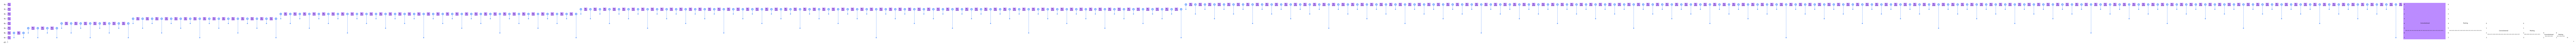

In [28]:
# Draw the quantum circuit and calculate the circuit depth.
circuit = qc_traditional    # qc_traditional
circuit_depth = circuit.decompose(reps=20).depth()
circut_params = circuit.num_parameters
print("circuit depth:", circuit_depth)
print("circut parameters:", circut_params)


circuit.draw('mpl', fold=-1)
# circuit.decompose().draw('mpl', fold=-1)

In [29]:
print("The number of Encoding parameters:", 2**num_qubits)
print("The number of circuit parameters:",  circuit.num_parameters-2**num_qubits)
# print(qc.parameters)

The number of Encoding parameters: 256
The number of circuit parameters: 60


## Define torch NN module

In [30]:
# Define torch NN module
from torch import concat, sum as tsum
from torch.nn import (
    Module,
    Linear,
    Sequential,
    CELU,
    Sigmoid,
    Tanh
)
from qiskit_machine_learning.connectors import TorchConnector

def get_counts(x, num_measurements):
    # Calculates the probability of measuring zero on each qubit
    # separately from the measurement probability vector.

    size = 2**(num_measurements)
    # size = 2**(3*num_measurements)

    # idx = [v for i, v in enumerate(range(size)) if i % 2 < 1]
    idx = [v for i, v in enumerate(range(size)) if i % 2 == 0]
    new_x = tsum(x[:,idx], 1, keepdim=True)

    for bit in range(1, num_measurements):
        idx = [v for i, v in enumerate(range(size)) if i % 2**(bit+1) < 2**bit]
        new_x = concat([new_x, tsum(x[:,idx], 1, keepdim=True)], 1)

    return new_x

class Net(Module):
    def __init__(self, qnn, layers_sizes, traditional_qcnn=False):
        input_size, hidden_size, output_size = layers_sizes
        super().__init__()
        if not traditional_qcnn:
            self.linear_relu_stack = Sequential(
                Linear(input_size, hidden_size),
                CELU(),
                Linear(hidden_size, hidden_size),
                CELU(),
                Linear(hidden_size, output_size),
                Tanh()   # Tanh()
            )
        self.qnn = TorchConnector(qnn)
        self._traditional_qcnn = traditional_qcnn

    def forward(self, x):
        if self._traditional_qcnn:
            x = get_counts(self.qnn(x), num_measurements = 1)
        else:
            x = get_counts(self.qnn(x), num_measurements=num_measurements)
            x = self.linear_relu_stack(x)

        print(x.reshape(-1))
        return x.reshape(-1)

input_size = num_measurements
layers_sizes = (input_size, 3 * input_size, 1)

In [31]:
print(input_size)
print(layers_sizes)

1
(1, 3, 1)


## Training

### Train traditional QCNN model

In [32]:
# Load time related packages
import time
import datetime

# Define model, optimizer, and loss function
import torch.optim as optim
from torch.nn import CrossEntropyLoss, MSELoss

model_traditional = Net(qnn_traditional, layers_sizes, traditional_qcnn=True)
optimizer = optim.Adam(model_traditional.parameters(), lr=0.01)
loss_func = MSELoss()
# loss_func = CrossEntropyLoss()

# Save model's initial parameters
torch.save(model_traditional.state_dict(), f'{result_folder_name}\model_traditional_ep0_{date_time_str}.pt')

In [33]:
print("Optimizer:", optimizer.__class__.__name__)
print("Loss function:", loss_func.__class__.__name__)

Optimizer: Adam
Loss function: MSELoss


In [34]:
from torchinfo import summary

# print("Batch size:", batch_size)
summary(model_traditional, input_size=(batch_size, 2**num_qubits))

tensor([0.4990, 0.5508, 0.5293, 0.5049, 0.5176])


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [5]                       --
├─TorchConnector: 1-1                    [5, 2]                    60
Total params: 60
Trainable params: 60
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [35]:
# Start training
epochs = 40     # Set number of epochs
loss_traditional_list = [] # Store loss history
model_traditional.train()  # Set model to training mode

start = time.time()
for epoch in range(1, epochs+1):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.squeeze()
        # target = tensor(target, dtype=float32)
        target = target.clone().detach().float()

        optimizer.zero_grad(set_to_none=True) # Initialize gradient
        output = model_traditional(data)                  # Forward pass
        loss = loss_func(output, target)      # Calculate loss
        loss.backward()                       # Backward pass
        optimizer.step()                      # Optimize weights
        total_loss.append(loss.item())        # Store loss

    loss_traditional_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * epoch / epochs, loss_traditional_list[-1]))
    
    # Save the model parameter checkpoint after each epoch
    torch.save(model_traditional.state_dict(), f'{result_folder_name}\model_traditional_ep%d_{date_time_str}.pt'%epoch)
end = time.time()


# Output the time duration of the optimization
sec = (end - start)
result = datetime.timedelta(seconds=sec)
result_list = str(datetime.timedelta(seconds=sec)).split(".")   # split the 'second' and 'microsecond'
print("Training Duration:", result_list[0])    # print the result without 'microsecond'.

tensor([0.5654, 0.6250, 0.5654, 0.5928, 0.5889],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6201, 0.6396, 0.6250, 0.5508, 0.5908],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6465, 0.6396, 0.5801, 0.6289, 0.6162],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6631, 0.6396, 0.6250, 0.6338, 0.6357],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6465, 0.6279, 0.6309, 0.6201, 0.6055],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6514, 0.5986, 0.6562, 0.6299, 0.5791],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6826, 0.6035, 0.6250, 0.6104, 0.5996],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6436, 0.6562, 0.6250, 0.6553, 0.5762],
       grad_fn=<ReshapeAliasBackward0>)
Training [2%]	Loss: 0.2401
tensor([0.6289, 0.6396, 0.6367, 0.6504, 0.5928],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6445, 0.6445, 0.6240, 0.6387, 0.5889],
       grad_fn=<ReshapeAliasBackward0>)
tensor([0.6494, 0.6221, 0.6055, 0.5957, 0.5850],
       grad_fn=<ReshapeAliasBackwa

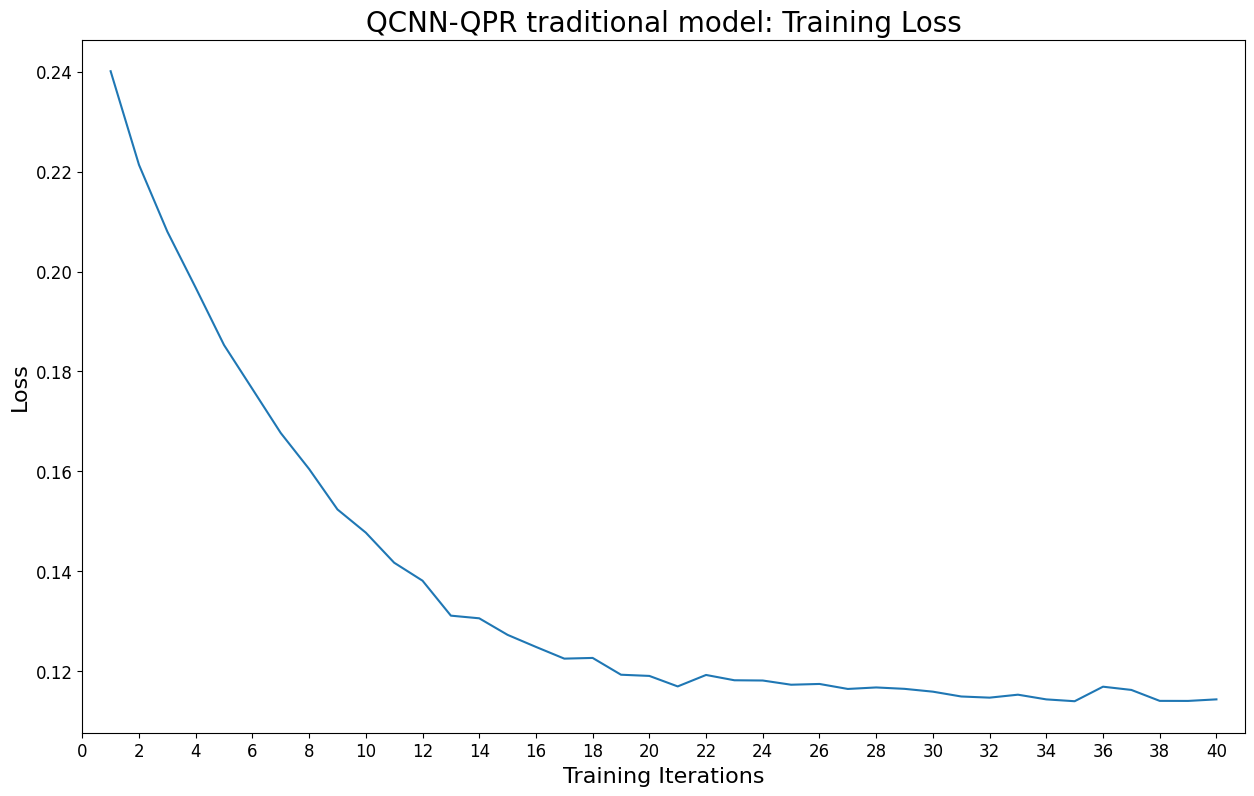

In [36]:
# Plot loss convergence
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
plt.plot(range(1, len(loss_traditional_list) + 1), loss_traditional_list)
plt.title("QCNN-QPR traditional model: Training Loss", fontsize=20)
plt.xlabel("Training Iterations", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xlim(1, epochs+1)
plt.xticks(range(0, epochs+2, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'{result_folder_name}\model_traditional_training_plot_{date_time_str}.png')
plt.show()

In [37]:
# Create the object name for model
model_file_name = f'{result_folder_name}\model_traditional_{date_time_str}.pt'
print(model_file_name)

torch.save(model_traditional.state_dict(), model_file_name)

result_simul\20230921\model_traditional_20230921_112322.pt


## Testing (Forward passing only)
- We want only to get the estimated $y$ values since we don't have the true labels of the test data.

### Testing with test dataset, model_traditional with initial parameters

In [38]:
print(date_time_str)

20230921_112322


In [40]:
# Initialize the test model with all the parameter values equal to zero.
model_traditional_test0 = Net(qnn_traditional, layers_sizes, traditional_qcnn=True)
# Load the saved state dictionary
model_traditional_test0.load_state_dict(torch.load(f'{result_folder_name}\model_traditional_ep0_{date_time_str}.pt'))

<All keys matched successfully>

In [41]:
from torch import no_grad

model_traditional_test0.eval()  # set model to evaluation mode
with no_grad():
    test_output_list = []
    # test_pred_list = []
    test_total_loss = []
    for idx, (data) in enumerate(test_loader):
        output = model_traditional_test0(data)
        
        pred = np.round(output, 0)
        # pred = torch.where(output > 0, torch.tensor(1), torch.tensor(-1))
        
        # Append the output and pred tensors to their respective lists
        test_output_list.append(output)
        # test_pred_list.append(pred)

    test_output_list = torch.cat(test_output_list, 0)
    # test_pred_list = torch.cat(test_pred_list, 0)

tensor([0.5693, 0.5742, 0.5645, 0.5498, 0.5527])
tensor([0.5684, 0.5723, 0.5645, 0.5488, 0.5527])
tensor([0.5684, 0.5713, 0.5645, 0.5479, 0.5527])
tensor([0.5674, 0.5684, 0.5615, 0.5459, 0.5498])
tensor([0.5654, 0.5664, 0.5596, 0.5439, 0.5479])
tensor([0.5654, 0.5654, 0.5586, 0.5439, 0.5469])
tensor([0.5654, 0.5635, 0.5586, 0.5430, 0.5459])
tensor([0.5654, 0.5625, 0.5566, 0.5420, 0.5459])
tensor([0.5654, 0.5684, 0.5654, 0.5537, 0.5684])
tensor([0.5928, 0.6045, 0.5986, 0.5947, 0.5889])
tensor([0.6309, 0.6318, 0.6250, 0.6191, 0.6074])
tensor([0.6436, 0.6406, 0.6270, 0.6221, 0.6094])
tensor([0.6445, 0.6416, 0.6279, 0.6260, 0.5527])
tensor([0.5693, 0.5742, 0.5645, 0.5498, 0.5527])
tensor([0.5684, 0.5723, 0.5645, 0.5488, 0.5527])
tensor([0.5684, 0.5703, 0.5635, 0.5469, 0.5527])
tensor([0.5654, 0.5664, 0.5596, 0.5439, 0.5469])
tensor([0.5654, 0.5645, 0.5586, 0.5439, 0.5469])
tensor([0.5654, 0.5635, 0.5586, 0.5439, 0.5469])
tensor([0.5654, 0.5625, 0.5566, 0.5420, 0.5420])
tensor([0.5635, 0.56

#### Plot the heatmap

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# # Create two separate arrays of h1 and h2.
h1_vals = [x for x, y in h1h2_test]
h2_vals = [y for x, y in h1h2_test]

# The order of h1 and h2 as a 2-dimensional array (row=h2, column=h1), the values are calculated with a fixed column value.

# Function that outputs the duplicated values. So that we get the coordinate arrays of h1 and h2.
def remove_duplicates_and_sort(arr):
    # Convert to a Python list (if not already)
    arr_list = list(arr)

    # Remove duplicates using set()
    unique_elements = set(arr_list)

    # Sort the unique elements in ascending order
    sorted_list = sorted(unique_elements)
    
    return sorted_list

h1_coordinate = remove_duplicates_and_sort(h1_vals)
h2_coordinate = remove_duplicates_and_sort(h2_vals)

# Reshape the output_list to proper heatmap data
heatmap_data = test_output_list.reshape((len(h1_coordinate), len(h2_coordinate)))

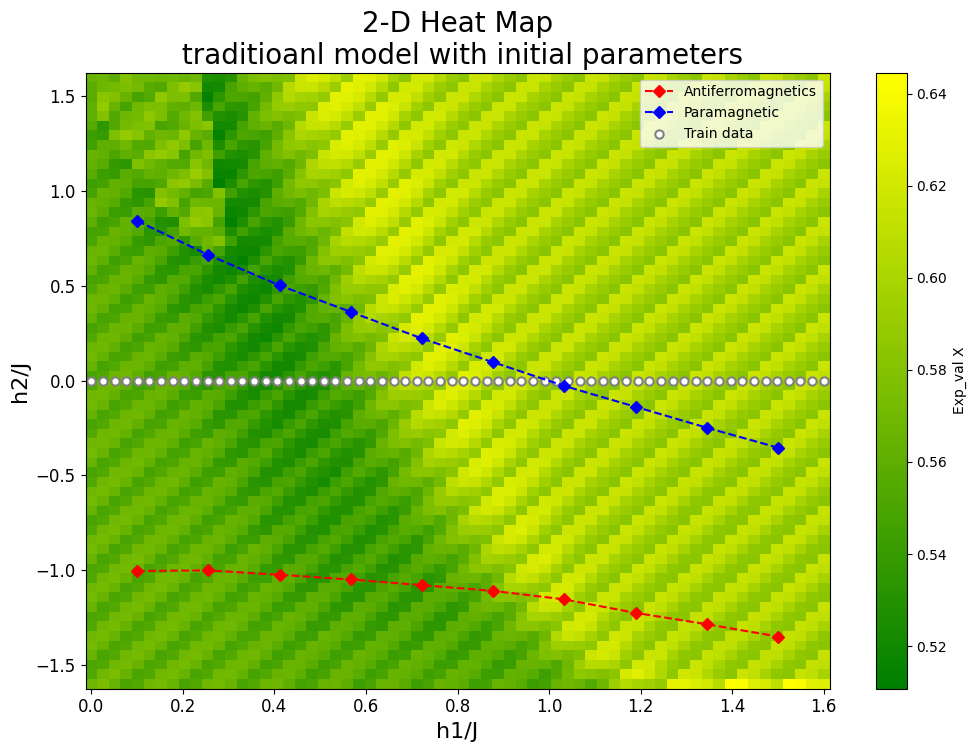

<Figure size 640x480 with 0 Axes>

In [43]:
# Create a gradient colormap from green to yellow
colors = ['green', 'yellow']
n_bins = 100  # Number of color bins for the gradient
cmap_name = "green_to_yellow"
cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# plot heat map
plt.figure(figsize=(12, 8))  # figsize = (length, width)
heat_map = plt.pcolormesh(h1_coordinate, h2_coordinate, heatmap_data, cmap = cmap)
plt.colorbar(heat_map, label="Exp_val X")
plt.title("2-D Heat Map\n traditioanl model with initial parameters", fontsize=20)
plt.xlabel('h1/J', fontsize=16)
plt.ylabel('h2/J', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plot phase boundaries
h1_vals_boundary = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

plt.plot(h1_vals_boundary, anti_ferro_mag_boundary, "r--D", label="Antiferromagnetics")
plt.plot(h1_vals_boundary, para_mag_boundary, "b--D", label="Paramagnetic")
plt.scatter(h1_coordinate, np.zeros_like(h1_coordinate), color='white', marker='o', facecolors='white', linewidths=1.5, edgecolors='grey', label='Train data')
plt.legend()

# Save the heatmap as an image
plt.savefig(f'{result_folder_name}/test_heatmap_model_traditional_ep0_{date_time_str}.png', dpi=1000)

plt.show()

- The <font color="blue">blue</font> and <font color="red">red</font> diamonds are phase boundary points extracted from infinite-size DMRG numerical simulates, while the background shading (color scale) represents the expectation value of QCNN output.

### Testing with test dataset, model_traditional with optimized parameters

In [46]:
# Initialize the test model with all the parameter values equal to zero.
model_traditional_test = Net(qnn_traditional, layers_sizes, traditional_qcnn=True)
# Load the saved state dictionary
model_traditional_test.load_state_dict(torch.load(f'{result_folder_name}\model_traditional_ep{epoch}_{date_time_str}.pt'))

<All keys matched successfully>

In [47]:
from torch import no_grad

model_traditional_test.eval()  # set model to evaluation mode
with no_grad():
    test_output_list = []
    # test_pred_list = []
    test_total_loss = []
    for idx, (data) in enumerate(test_loader):
        output = model_traditional_test(data)
        
        pred = np.round(output, 0)
        # pred = torch.where(output > 0, torch.tensor(1), torch.tensor(-1))
        
        # Append the output and pred tensors to their respective lists
        test_output_list.append(output)
        # test_pred_list.append(pred)

    test_output_list = torch.cat(test_output_list, 0)
    # test_pred_list = torch.cat(test_pred_list, 0)

tensor([0.6602, 0.6523, 0.6426, 0.6436, 0.6348])
tensor([0.6660, 0.6543, 0.6504, 0.6504, 0.6436])
tensor([0.6768, 0.6650, 0.6689, 0.6621, 0.6582])
tensor([0.7002, 0.6807, 0.6875, 0.6914, 0.6807])
tensor([0.7188, 0.6992, 0.7070, 0.7139, 0.6992])
tensor([0.7334, 0.7207, 0.7197, 0.7295, 0.7207])
tensor([0.7471, 0.7412, 0.7383, 0.7529, 0.7490])
tensor([0.7773, 0.7666, 0.7773, 0.7783, 0.7852])
tensor([0.8135, 0.8037, 0.8145, 0.8018, 0.8047])
tensor([0.8066, 0.7754, 0.7471, 0.7256, 0.6758])
tensor([0.6807, 0.6406, 0.5996, 0.5684, 0.5576])
tensor([0.5605, 0.5508, 0.5215, 0.5107, 0.4912])
tensor([0.5068, 0.5117, 0.4795, 0.4736, 0.6299])
tensor([0.6611, 0.6543, 0.6436, 0.6436, 0.6377])
tensor([0.6680, 0.6582, 0.6514, 0.6523, 0.6445])
tensor([0.6836, 0.6680, 0.6738, 0.6670, 0.6641])
tensor([0.7041, 0.6875, 0.6934, 0.6973, 0.6846])
tensor([0.7246, 0.7080, 0.7158, 0.7188, 0.7090])
tensor([0.7393, 0.7285, 0.7256, 0.7363, 0.7334])
tensor([0.7627, 0.7480, 0.7529, 0.7656, 0.7686])
tensor([0.7939, 0.78

In [48]:
print(test_output_list.shape)
test_output_list

torch.Size([4096])


tensor([0.6602, 0.6523, 0.6426,  ..., 0.3105, 0.2939, 0.2871])

### Plot the heatmap

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# # Create two separate arrays of h1 and h2.
h1_vals = [x for x, y in h1h2_test]
h2_vals = [y for x, y in h1h2_test]

# The order of h1 and h2 as a 2-dimensional array (row=h2, column=h1), the values are calculated with a fixed column value.

# Function that outputs the duplicated values. So that we get the coordinate arrays of h1 and h2.
def remove_duplicates_and_sort(arr):
    # Convert to a Python list (if not already)
    arr_list = list(arr)

    # Remove duplicates using set()
    unique_elements = set(arr_list)

    # Sort the unique elements in ascending order
    sorted_list = sorted(unique_elements)
    
    return sorted_list

h1_coordinate = remove_duplicates_and_sort(h1_vals)
h2_coordinate = remove_duplicates_and_sort(h2_vals)

# Reshape the output_list to proper heatmap data
heatmap_data = test_output_list.reshape((len(h1_coordinate), len(h2_coordinate)))

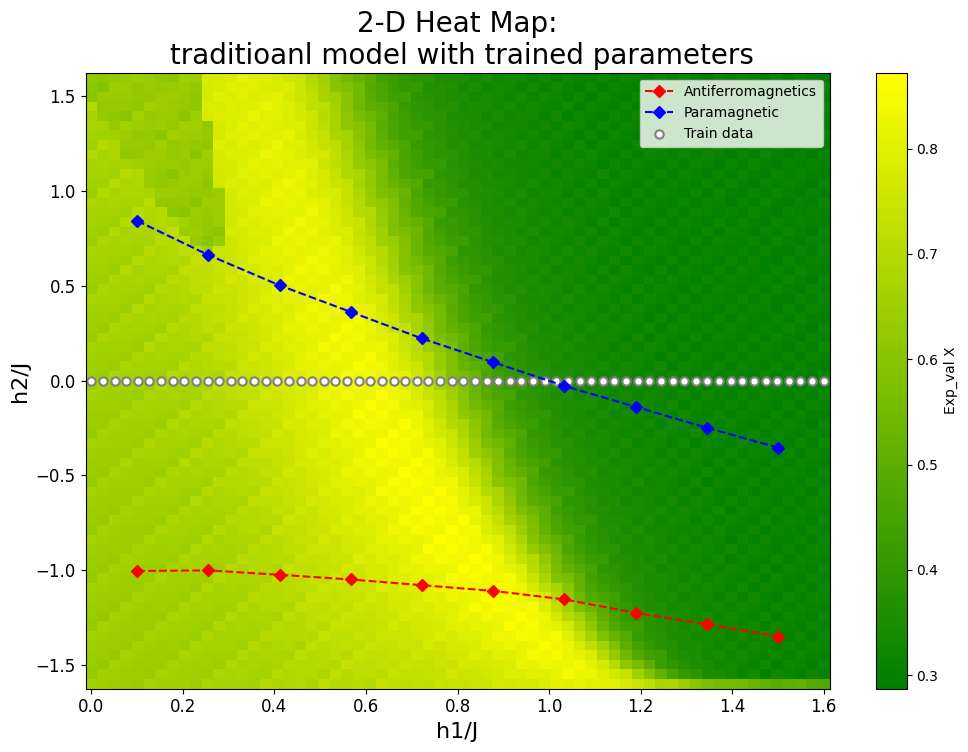

In [53]:
# Create a gradient colormap from green to yellow
colors = ['green', 'yellow']
n_bins = 100  # Number of color bins for the gradient
cmap_name = "green_to_yellow"
cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# plot heat map
plt.figure(figsize=(12, 8))  # figsize = (length, width)
heat_map = plt.pcolormesh(h1_coordinate, h2_coordinate, heatmap_data, cmap = cmap)
plt.colorbar(heat_map, label="Exp_val X")
plt.title("2-D Heat Map:\n traditioanl model with trained parameters", fontsize=20)
plt.xlabel('h1/J', fontsize=16)
plt.ylabel('h2/J', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plot phase boundaries
h1_vals_boundary = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

plt.plot(h1_vals_boundary, anti_ferro_mag_boundary, "r--D", label="Antiferromagnetics")
plt.plot(h1_vals_boundary, para_mag_boundary, "b--D", label="Paramagnetic")
plt.scatter(h1_coordinate, np.zeros_like(h1_coordinate), color='white', marker='o', facecolors='white', linewidths=1.5, edgecolors='grey', label='Train data')
plt.legend()

# Save the heatmap as an image
plt.savefig(f'{result_folder_name}/test_heatmap_model_traditional_ep{epoch}_{date_time_str}.png', dpi=1000)

plt.show()

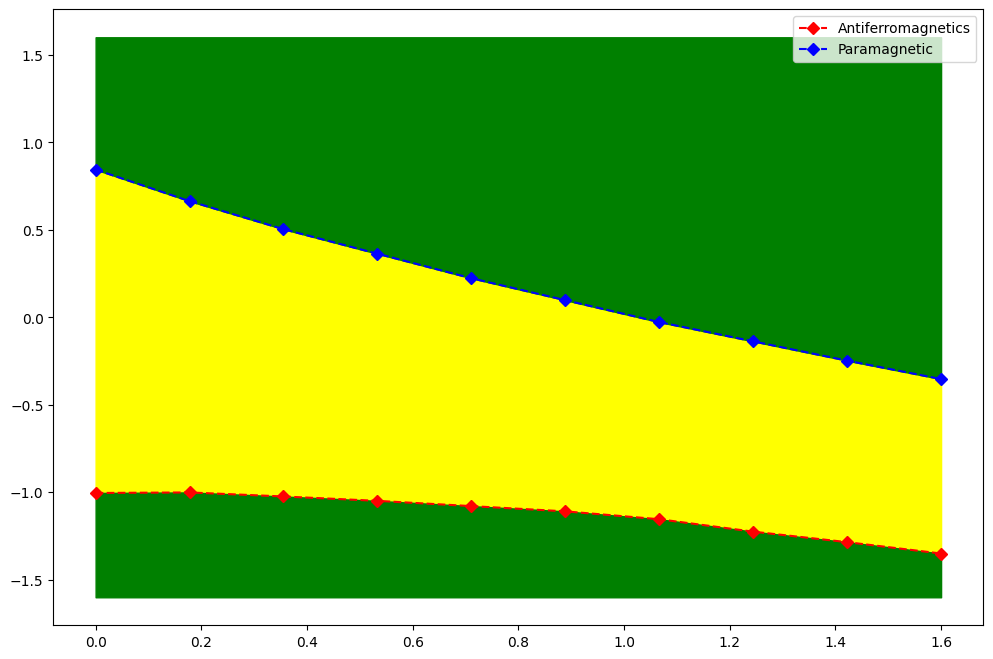

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Your code for initial_predictions and heat map plotting...

# Plot phase boundaries
h1_vals = np.linspace(0, 1.6, 10)
h2_vals = np.linspace(-1.6, 1.6, 10)

anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154, -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531]

# Plot the curves
plt.figure(figsize=(12, 8))  # figsize = (length, width)
plt.plot(h1_vals, anti_ferro_mag_boundary, "r--D", label="Antiferromagnetics")
plt.plot(h1_vals, para_mag_boundary, "b--D", label="Paramagnetic")

# Fill the area between the curves with green
plt.fill_between(h1_vals, para_mag_boundary, anti_ferro_mag_boundary, color='yellow', alpha=1.0)
plt.fill_between(h1_vals, para_mag_boundary, 1.6, color='green', alpha=1.0)
plt.fill_between(h1_vals, h2_vals[0], anti_ferro_mag_boundary, color='green', alpha=1.0)

# Scatter plot of the train data (h1, 0) points
# plt.scatter(h1_coordinate, np.zeros_like(h1_coordinate), color='white', marker='o', facecolors='white', linewidths=1.5, edgecolors='grey', label='Train data')

# Scatter plot of the test data (h1, h2) points
# plt.scatter([x for x, y in h1h2_test], [y for x, y in h1h2_test], color='red', marker='o', facecolors='red', s=1.0, label='Test data')


plt.legend()
plt.show()

# plt.savefig("test_heatmap_ideal.png", dpi=1000)

In [52]:
# Install python-telegram-bot package
# %pip install python-telegram-bot

# Import `telegram` and insert API_KEY and chat_id
import telegram
# API_KEY from your own bot.
API_KEY = '5618308244:AAGRuOdOcJaISPoaFQH-V4G1GBQ6VmK6ddY'
chat_id = '5687601473'   # your telegram chat id

# Enable your Telegram Bot
bot = telegram.Bot(token=API_KEY)  # bot을 선언합니다.
updates = bot.getUpdates()
updates

# Send message through Telegram when the code is done executed
try:
    a = 2
except:
    await bot.sendMessage(chat_id=chat_id, text="QCNN_QPR-THK - simul_trad 코드 실행이 실패하였습니다.")
else:
    await bot.sendMessage(chat_id=chat_id, text="QCNN_QPR-THK - simul_trad 코드 실행이 성공적으로 진행되었습니다.")
